# 安裝必要套件\掛載Google drive

In [ ]:
!pip install -U requests beautifulsoup4 pandas openpyxl matplotlib wordcloud google-generativeai

In [ ]:
import os
import google.generativeai as genai
from google.colab import drive, userdata
from datetime import datetime, timedelta, timezone

# 搜尋以及功能設定

In [ ]:
# ================= CONFIGURATION START =================

# 1. Google Gemini API Key
"""
請到 https://aistudio.google.com/ 申請一組free tier或以上的API密碼，

可以使用colab的Secrets(左側鑰匙圖樣)將API儲存起來，並取名為GEMINI_API_KEY，設定的程式碼會自動引入直接使用；

或是在下方GEMINI_API_KEY = "請在此填入Key作為備用"，直接填入API KEY (不建議這樣做) 。

切記，請勿外流您的API KEY。
"""
try:
    # 嘗試從 Colab Secrets 讀取
    GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')
    print("🔑 已從 Secrets 安全讀取 API Key")
except Exception as e:
    # 如果讀取失敗 (例如沒設定 Secrets)，提醒使用者
    print("⚠️ 未偵測到 Secrets，請確認是否已在左側 '鑰匙' 圖示中設定 'GOOGLE_API_KEY'")
    GEMINI_API_KEY = "請在此填入Key作為備用"

# 2. 監測主題
MONITOR_CONFIG = {
    # 1. 科技巨頭：展示 AI 擴展能否抓到具體產品 (如 Blackwell, CoWoS)
    "科技趨勢": ["輝達 NVIDIA", "OpenAI", "鴻海"],

    # 2. 消費品牌：這是展示「語意過濾」的最佳戰場
    #    (星巴克/好市多常有「奧客事件」或「社會案件」，看 AI 能否剔除，只留營運/促銷)
    "品牌動態": ["星巴克", "好市多 Costco", "特斯拉 Tesla"],

    # 3. 高波動資產：展示 AI 識別「詐騙」與「財經分析」的能力
    #    (比特幣常混雜詐騙新聞；黃金常混雜銀樓搶案)
    "金融市場": ["比特幣", "黃金價格", "00940"]
}

# 3. 爬蟲設定
# 新聞收集回推時間
LOOKBACK_DAYS = 3
# 每個關鍵字查找筆數上限
MAX_ITEMS_PER_KEYWORD = 50

# 4. AI 設定
ENABLE_KEYWORD_EXPANSION = True
ENABLE_AI_SUMMARY = True
ENABLE_SENTIMENT = True
BATCH_SIZE = 50

# 5. 輸出設定
# 使用此設定在Google Drive中建立"News_Crawler_Reports"資料夾存放結果報告
OUTPUT_FOLDER = "/content/drive/My Drive/News_Crawler_Reports"

# ================= CONFIGURATION END =================

🔑 已從 Secrets 安全讀取 API Key


# 程式碼區塊

### 模組 A: 全局配置 (Configuration)

In [ ]:
# 初始化 Gemini
if ENABLE_AI_SUMMARY and GEMINI_API_KEY and GEMINI_API_KEY != "請在此填入Key作為備用":
    genai.configure(api_key=GEMINI_API_KEY)

    # 指定模型
    target_model = 'gemini-2.5-flash-lite'

    try:
        model = genai.GenerativeModel(target_model)
        print(f"✅ 已成功連接模型: {target_model}")
    except Exception as e:
        print(f"⚠️ 連接 {target_model} 失敗: {e}")
        print("🔄 嘗試切換至備援模型: gemini-2.0-flash")
        model = genai.GenerativeModel('gemini-2.0-flash')
else:
    print("⚠️ 未設定 API Key，AI 功能將無法使用。")

# 掛載 Google Drive
def setup_drive():
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    tz_tw = timezone(timedelta(hours=8))
    today_str = datetime.now(tz_tw).strftime("%Y-%m-%d")
    target_path = os.path.join(OUTPUT_FOLDER, today_str)
    if not os.path.exists(target_path):
        os.makedirs(target_path)

    print(f"✅ 雲端儲存路徑已確認: {target_path}")
    return target_path

OUTPUT_PATH = setup_drive()

✅ 已成功連接模型: gemini-2.5-flash-lite
✅ 雲端儲存路徑已確認: /content/drive/My Drive/News_Crawler_Reports/2025-11-27


In [ ]:
import json
import time
import google.generativeai as genai

def expand_keywords_structured(original_config):
    """
    AI 關鍵字擴展
    策略：情境自適應 (Context-Adaptive)
    特點：不限定領域，根據「主題」自動判斷該找公司、找法案、還是找熱門商品。
    """
    print("🧠 正在啟動 AI 關鍵字擴展引擎...")

    now = datetime.now()
    current_year_str = now.strftime("%Y")       # e.g., "2025"
    current_month_str = now.strftime("%Y年%m月") # e.g., "2025年11月"

    structured_config = {}

    for topic, keywords in original_config.items():
        structured_config[topic] = {}

        # 取得該主題下的所有源頭關鍵字，供 AI 參考以避免撞車
        siblings = ", ".join(keywords)

        for base_kw in keywords:
            print(f"   🌿 源頭關鍵字 [{base_kw}] ({topic}) 分析中...")

            # --- Prompt 通用化升級 ---
            prompt = f"""
            你是一名精通「台灣新聞熱點」與了解「關鍵字相關性」的資深新聞編輯。
            **現在的時間是：{current_month_str}。**
            我的監測主題是「{topic}」，目前設定的源頭關鍵字清單包含：[{siblings}]。
            請針對「{base_kw}」這個關鍵字，先針對這個時間點先初步研究提供給你的關鍵字。
            再提供 2 個「**{current_month_str}當下最具新聞價值」且「具備搜尋區別度」的繁體中文新聞搜尋關鍵字。
            **盡量提供符合主題框架且具備延伸性的關鍵字**

            【思考策略：請根據「{topic}」的性質調整策略】
            1. 若是**產業/科技/財經**：請找出「龍頭企業」、「核心技術」、「具體產品型號」或「關鍵數據指標」。
            2. 若是**社會/政策/環保**：請找出「法案名稱」、「專有現象名詞」(如:行人地獄)、「核心人物」或「爭議事件」。
            3. 若是**生活/品牌/消費**：請找出「熱門品項」、「促銷活動名稱」、「競爭對手」或「關聯平台」。

            【時效性規則】
            1. ❌ **禁止歷史舊聞**：絕對不要提供不是新聞的過期爭議。
            2. ✅ **鎖定近期動態**：
               - 若是政治/外交，搜最近 3 個月的談話或事件（如：最新軍售進度、世界重要會議）。
               - 若是財經，搜當季的數據或趨勢。
            3. ✅ **加上年份/時間詞**：若該議題具週期性，請加上「{current_month_str}」或「最新」。

            【嚴格的思考路徑】
            1. ❌ **絕對禁止名詞解釋**：若源頭是「CPI」，禁止回傳「消費者物價指數」（這是無效擴展）。
            2. ❌ **絕對禁止單純同義詞**：若源頭是「台股」，禁止回傳「台灣股市」。
            3. ✅ **尋找「驅動因子」**：
               - 產品類：加上**主打功能**或**產品特色**（如：iPhone 17 pro -> **相機**）。
               - 金融類：加上趨勢動詞（如：台幣 -> **重貶**、央行 -> **干預**）。
               - 產業類：找出**領漲族群**或**特定技術**（如：台股 -> **AI伺服器**、**重電股**）。
               - 政策類：找出**具體法案**或**爭議點**（如：房市政策 -> **新青安**、**囤房稅2.0**）。

            【輸出範例參考】
            務必記得參考查詢當下或日期區間內的社會趨勢，但無須過度組合、延伸關鍵字
            - (金融) 輸入: 美國聯準會 -> 輸出: ["鮑爾 談話", "降息 時間表"] (捕捉市場預期)
            - (產業) 輸入: 半導體 -> 輸出: ["CoWoS 產能", "先進封裝"] (捕捉技術瓶頸)
            - (政策) 輸入: 房市政策 -> 輸出: ["新青安 違規", "央行 限貸令"] (捕捉熱門議題)
            - (社會) 輸入: 少子化 -> 輸出: ["人工生殖法", "龍年 生育率"] (捕捉法規與數據)
            - (消費) 輸入: 出國旅遊 -> 輸出: ["機票 促銷", "日幣 匯率"] (捕捉成本誘因)


            請回傳 JSON String List(只取最好的 2 個)，範例：["關鍵字A", "關鍵字B"]
            """

            search_terms = [base_kw] # 預設包含自己

            try:
                # 呼叫 Gemini
                response = model.generate_content(prompt)
                text = response.text.strip()

                # 清理 Markdown 標記
                if "```json" in text:
                    text = text.split("```json")[1].split("```")[0].strip()
                elif "```" in text:
                    text = text.split("```")[1].strip()

                ai_suggestions = json.loads(text)

                # 過濾與加入
                for term in ai_suggestions:
                    if term == base_kw: continue
                    # 簡單過濾：若建議詞太短或是單純的包含關係，可能效益不高
                    if len(term) > len(base_kw) and base_kw in term and len(term) - len(base_kw) < 2:
                        continue
                    search_terms.append(term)

                # 去重
                structured_config[topic][base_kw] = list(set(search_terms))

                print(f"      └── 🍃 深度關鍵字: {structured_config[topic][base_kw]}")
                time.sleep(2)

            except Exception as e:
                print(f"      ⚠️ 擴展失敗 ({e})，僅使用原始關鍵字。")
                structured_config[topic][base_kw] = [base_kw]

    return structured_config

### 模組 B: 基礎工具與網路請求 (Utils & Network)

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
import urllib.parse
from datetime import datetime, timedelta
from email.utils import parsedate_to_datetime
from concurrent.futures import ThreadPoolExecutor, as_completed

# ==========================================
# 基礎工具：請求核心
# ==========================================

try:
    LIMIT = MAX_ITEMS_PER_KEYWORD
except NameError:
    LIMIT = 10 # 預設備援

try:
    # 讓爬蟲知道時間界線，用於即時過濾
    DAYS_LIMIT = LOOKBACK_DAYS
except NameError:
    DAYS_LIMIT = 2

TW_TZ = timezone(timedelta(hours=8))

def get_now_tw():
    """取得台灣當下的 Naive Time (不帶時區標籤，方便計算)"""
    return datetime.now(TW_TZ).replace(tzinfo=None)

def get_random_header():
    """
    隨機產生 User-Agent，包含電腦版與手機版，
    讓爬蟲看起來像來自不同裝置的流量。
    """
    user_agents = [
        # Chrome Windows
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36",
        # Chrome Mac
        "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.3 Safari/605.1.15",
        # Firefox Windows
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:123.0) Gecko/20100101 Firefox/123.0",
        # Edge
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36 Edg/123.0.0.0"
    ]

    return {
        "User-Agent": random.choice(user_agents),
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
        "Accept-Language": "zh-TW,zh;q=0.9,en-US;q=0.8,en;q=0.7",
        "Referer": "https://www.google.com/"
    }

def fetch_page_robust(url, source_name="Unknown", max_retries=3):
    """
    堅韌請求函式 (含 404/410 放棄邏輯)
    支援 RSS XML 解析
    """
    for attempt in range(max_retries):
        try:
            sleep_time = random.uniform(1.0, 2.0) + (attempt * 1.2) # 翻頁時稍微縮短延遲
            time.sleep(sleep_time)
            headers = get_random_header()
            response = requests.get(url, headers=headers, timeout=15)

            if response.status_code in [404, 410]:
                return None # 資源不存在，直接放棄

            if response.status_code == 200:
                # 如果是 RSS，使用 xml 解析器
                if "rss" in url or "xml" in response.headers.get('Content-Type', ''):
                    return BeautifulSoup(response.content, 'xml')
                else:
                    return BeautifulSoup(response.text, 'html.parser')

            # print(f"   ⚠️ [{source_name}] HTTP {response.status_code} (Retry {attempt+1})...")
        except Exception as e:
            # print(f"   ⚠️ [{source_name}] Err: {e} (Retry {attempt+1})...")
            pass

    return None

def parse_relative_time(time_str):
    """時間格式處理"""
    now = get_now_tw()
    time_str = str(time_str).strip()
    try:
        if "小時" in time_str or "hour" in time_str:
            hours = int(''.join(filter(str.isdigit, time_str)))
            return now - timedelta(hours=hours)
        elif "分" in time_str or "min" in time_str:
            mins = int(''.join(filter(str.isdigit, time_str)))
            return now - timedelta(minutes=mins)
        elif "天" in time_str or "day" in time_str or "昨" in time_str:
            days = 1
            if any(char.isdigit() for char in time_str):
                days = int(''.join(filter(str.isdigit, time_str)))
            return now - timedelta(days=days)
        else:
            for fmt in ("%Y-%m-%d %H:%M", "%Y/%m/%d %H:%M", "%Y-%m-%d", "%Y/%m/%d", "%Y.%m.%d"):
                try:
                    return datetime.strptime(time_str, fmt)
                except ValueError:
                    continue
            return now
    except:
        return now

def fetch_article_content(url, source):
    soup = fetch_page_robust(url, f"FullText_{source}")
    if not soup: return None, None

    content = ""
    actual_date = None

    try:
        # --- 1. 針對 Yahoo 的強力時間解析 (JSON-LD 優先) ---
        if source == "Yahoo新聞":
            container = soup.select_one(".caas-body")

            def convert_to_tw_time(iso_str):
                try:
                    # 先讀成 Aware UTC
                    dt_utc = datetime.fromisoformat(iso_str.replace('Z', '+00:00'))
                    # 轉成 台灣時區
                    dt_tw = dt_utc.astimezone(TW_TZ)
                    # 移除時區標籤 (變成 Naive) 以便存入 Excel
                    return dt_tw.replace(tzinfo=None)
                except: return None

            # [策略 A] JSON-LD (最穩定的後門)
            # Yahoo 通常會把資料藏在 <script type="application/ld+json"> 裡
            scripts = soup.find_all('script', type='application/ld+json')
            for script in scripts:
                try:
                    data = json.loads(script.string)
                    # 有時候是 list，有時候是 dict
                    if isinstance(data, list):
                        data = data[0]

                    # 找 datePublished
                    if 'datePublished' in data:
                        dt = datetime.fromisoformat(data['datePublished'].replace('Z', '+00:00'))
                        actual_date = dt.replace(tzinfo=None)
                        break
                except: continue

            # [策略 B] Meta Tag (備用)
            if not actual_date:
                meta_time = soup.select_one("meta[property='article:published_time']")
                if meta_time and meta_time.get('content'):
                    try:
                        dt = datetime.fromisoformat(meta_time['content'].replace('Z', '+00:00'))
                        actual_date = dt.replace(tzinfo=None)
                    except: pass

            # [策略 C] UI 顯示 (最後手段)
            if not actual_date:
                time_tag = soup.select_one(".caas-attr-meta-time time")
                if time_tag and time_tag.has_attr('datetime'):
                    try:
                        dt = datetime.fromisoformat(time_tag['datetime'].replace('Z', '+00:00'))
                        actual_date = dt.replace(tzinfo=None)
                    except: pass

        # --- 其他來源維持原樣 ---
        elif source == "自由時報":
            container = soup.select_one("div.text")
            if container:
                for trash in container.select(".promote, .author, .app_ad"): trash.decompose()
            time_tag = soup.select_one(".content_header .time")
            if time_tag: actual_date = parse_relative_time(time_tag.text)

        elif source == "聯合新聞":
            container = soup.select_one("section.article-content__editor")
            time_tag = soup.select_one("time.article-content__time")
            if time_tag: actual_date = parse_relative_time(time_tag.text)

        elif source == "ETtoday":
            container = soup.select_one("div.story")
            time_tag = soup.select_one("time[itemprop='datePublished']")
            if time_tag: actual_date = parse_relative_time(time_tag.text)

        else:
            container = soup.body

        # --- 2. 提取文字 ---
        if container:
            paragraphs = [p.text.strip() for p in container.find_all('p') if len(p.text) > 10]
            content = "\n".join(paragraphs)

        if len(content) < 50:
            paragraphs = [p.text.strip() for p in soup.find_all('p') if len(p.text) > 20]
            content = "\n".join(paragraphs)

    except Exception as e:
        # print(f"   ⚠️ 解析內文失敗 ({url}): {e}")
        pass

    return (content if len(content) > 50 else None), actual_date

def is_date_valid(date_obj):
    try:
        cutoff_date = get_now_tw() - timedelta(days=DAYS_LIMIT)
        # 確保傳入的 date_obj 也是 naive 的 (這在 fetch_article_content 會處理)
        if date_obj.tzinfo is not None:
            date_obj = date_obj.replace(tzinfo=None)
        return date_obj >= cutoff_date
    except: return True



###　模組 C: 針對性爬蟲解析器 (Parsers)

In [ ]:
# ==========================================
# 各大新聞網解析器
# ==========================================

def crawl_ltn(keyword):
    results = []
    page = 1

    while len(results) < LIMIT:
        url = f"https://search.ltn.com.tw/list?keyword={keyword}&page={page}"
        soup = fetch_page_robust(url, "自由時報")
        if not soup: break

        items = soup.select("ul.list > li")
        if not items: break

        new_count = 0
        for item in items:
            if len(results) >= LIMIT: break
            try:
                time_tag = item.select_one("span.time")
                date_time = parse_relative_time(time_tag.text) if time_tag else datetime.now()

                # 即時過濾：若日期太舊，跳過不收錄
                if not is_date_valid(date_time): continue

                link_tag = item.select_one("a.tit")
                if not link_tag: continue
                title = link_tag.text.strip()
                link = link_tag['href']

                results.append({"source": "自由時報", "title": title, "link": link, "date": date_time, "content": title})
                new_count += 1
            except: continue

        # 如果整頁都沒新資料(且已抓過資料)，可能代表後面都是舊聞了
        if new_count == 0 and len(results) > 0: break
        if new_count == 0 and page > 3: break # 安全機制
        page += 1

    return results

def crawl_udn(keyword):
    results = []
    page = 1

    while len(results) < LIMIT:
        url = f"https://udn.com/search/word/2/{keyword}/{page}"
        soup = fetch_page_robust(url, "聯合新聞")
        if not soup: break

        items = soup.select("div.story-list__text")
        if not items: break

        new_count = 0
        for item in items:
            if len(results) >= LIMIT: break
            try:
                time_tag = item.select_one("time")
                date_time = parse_relative_time(time_tag.text) if time_tag else datetime.now()

                # 即時過濾
                if not is_date_valid(date_time): continue

                h2_tag = item.select_one("h2 a")
                if not h2_tag: continue
                title = h2_tag.text.strip()
                link = h2_tag['href']
                p_tag = item.select_one("p")
                content = p_tag.text.strip() if p_tag else title
                results.append({"source": "聯合新聞", "title": title, "link": link, "date": date_time, "content": content})
                new_count += 1
            except: continue

        if new_count == 0 and len(results) > 0: break
        if new_count == 0 and page > 3: break
        page += 1

    return results

def crawl_ettoday(keyword):
    """
    使用 Google News RSS + site:ettoday.net 指令。
    """
    results = []
    encoded_kw = urllib.parse.quote(keyword)

    # 加入 when:{DAYS_LIMIT}d 讓 Google 幫忙篩選時間
    rss_url = f"https://news.google.com/rss/search?q={encoded_kw}+site:ettoday.net+when:{DAYS_LIMIT}d&hl=zh-TW&gl=TW&ceid=TW:zh-Hant"

    soup = fetch_page_robust(rss_url, "ETtoday_RSS")
    if not soup: return []

    items = soup.find_all("item")

    for item in items:
        if len(results) >= LIMIT: break
        try:
            pub_date_str = item.pubDate.text.strip()
            try:
                # 解析 RSS 時間 (RFC 822 格式)
                date_time = parsedate_to_datetime(pub_date_str)
                # 統一轉為無時區 (naive datetime) 以便比較
                if date_time.tzinfo is not None:
                    date_time = date_time.replace(tzinfo=None)
            except:
                date_time = datetime.now()

            # 即時過濾舊聞
            if not is_date_valid(date_time): continue

            # 移除標題尾綴
            title = item.title.text.strip().rsplit("-", 1)[0].strip()
            link = item.link.text.strip()

            results.append({
                "source": "ETtoday",
                "title": title,
                "link": link,
                "date": date_time,
                "content": title
            })
        except: continue

    return results

def crawl_yahoo(keyword):
    results = []
    offset = 1

    # Yahoo 加入 sort=date 參數，讓舊聞更容易被過濾
    base_url = "https://tw.news.yahoo.com/search?p={}&fr2=p%3As%2Cv%3Ai%2Cm%3Asb-top&sort=date&b={}"

    while len(results) < LIMIT:
        url = base_url.format(keyword, offset)
        soup = fetch_page_robust(url, "Yahoo")
        if not soup: break

        main_area = soup.select_one("#Stream") or soup.select_one("#main") or soup
        links_in_list = main_area.select("li a")
        if len(links_in_list) > 5:
            all_links = links_in_list
        else:
            all_links = main_area.find_all("a")

        if not all_links: break

        new_count = 0
        seen_links = set()
        title_blacklist = ["下載", "隱私", "條款", "政策", "廣告", "服務", "信箱", "股市", "氣象", "運動", "名人",
                           "影音", "焦點", "首頁", "搜尋", "登入", "指南", "懶人包", "Yahoo", "拍賣", "購物"]

        for link_tag in all_links:
            if len(results) >= LIMIT: break
            try:
                title = link_tag.text.strip()
                href = link_tag.get('href')

                # --- V5 精準過濾 ---
                if not href or not title: continue
                if len(title) < 12: continue
                if title.startswith("Yahoo") and len(title) < 20: continue
                if any(b_word in title for b_word in title_blacklist): continue
                if "/topic/" in href or "/tag/" in href or "/search" in href: continue
                if ".html" not in href: continue
                if href.startswith("/"): href = "https://tw.news.yahoo.com" + href

                # Yahoo 列表頁通常沒日期，我們假設它是新的 (因為有 sort=date)
                # 但在去重檢查後再加入
                is_duplicate = False
                for r in results:
                    if r['link'] == href:
                        is_duplicate = True
                        break
                if is_duplicate or href in seen_links: continue

                seen_links.add(href)
                results.append({
                    "source": "Yahoo新聞",
                    "title": title,
                    "link": href,
                    "date": datetime.now(),
                    "content": title
                })
                new_count += 1
            except: continue

        if new_count == 0: break
        offset += 10
        if offset > 50: break # 安全機制

    return results

# ==========================================
# 總控中心
# ==========================================

def crawl_manager(nested_config):
    all_data = []
    print(f"\n🕷️ 開始執行樹狀爬取 (Limit={LIMIT}, Lookback={DAYS_LIMIT}天)...")

    # 建立執行緒池 (Thread Pool)
    # max_workers=4 對應 4 個來源
    with ThreadPoolExecutor(max_workers=4) as executor:

        for topic, base_map in nested_config.items():
            print(f"\n📂 主題: {topic}")
            for root_kw, search_terms in base_map.items():
                print(f"   🌿 源頭: {root_kw}")

                for search_kw in search_terms:
                    prefix = "      --" if search_kw != root_kw else "      ->"
                    print(f"{prefix}正在搜尋: {search_kw}")

                    # 定義要執行的任務清單
                    # 格式: executor.submit(函式名稱, 參數)
                    future_to_source = {
                        executor.submit(crawl_ltn, search_kw): "LTN",
                        executor.submit(crawl_yahoo, search_kw): "Yahoo",
                        executor.submit(crawl_udn, search_kw): "UDN",
                        executor.submit(crawl_ettoday, search_kw): "ETtoday"
                    }

                    # 等待所有任務完成並收集結果
                    for future in as_completed(future_to_source):
                        source_name = future_to_source[future]
                        try:
                            data = future.result()

                            # 補上標籤 (Tagging)
                            for item in data:
                                item['topic'] = topic
                                item['root_keyword'] = root_kw
                                item['keyword'] = search_kw

                            all_data.extend(data)
                        except Exception as e:
                            print(f"         ⚠️ [{source_name}] 發生錯誤: {e}")

                    # 稍微休息，避免瞬間請求過多導致 Colab 網路塞車
                    time.sleep(0.5)

    print(f"\n✅ 全數爬取完成，共收集 {len(all_data)} 則資料。")
    return pd.DataFrame(all_data)

### 模組 D: 資料清洗與 AI 批量處理 (Clean & AI Batch)

In [ ]:
import pandas as pd
import json
import re
import time
import google.generativeai as genai
import difflib
from datetime import datetime, timedelta, timezone
from concurrent.futures import ThreadPoolExecutor, as_completed

TW_TZ = timezone(timedelta(hours=8))

def get_now_tw():
    """取得台灣當下時間 (Naive)"""
    return datetime.now(TW_TZ).replace(tzinfo=None)

def clean_and_filter_data(df, lookback_days):
    """
    1. 時間篩選
    2. 網址完全去重
    3. 標題模糊去重 (Fuzzy Deduplication)
    """
    if df.empty: return df

    # 1. 時間篩選
    cutoff_date = get_now_tw() - timedelta(days=lookback_days)
    df = df[df['date'] >= cutoff_date]

    # 2. 網址完全去重
    df = df.drop_duplicates(subset=['link'])

    # 3. 標題模糊去重演算法
    # 目的：過濾掉「換湯不換藥」的高度相似標題
    print(f"🧹 開始清洗... (原始筆數: {len(df)})")

    # 先將標題轉為列表
    titles = df['title'].tolist()
    keep_indices = []
    seen_titles = []

    for i, title in enumerate(titles):
        is_duplicate = False
        # 與已經保留的標題進行比對
        for seen in seen_titles:
            # 計算相似度 (0.0 ~ 1.0)
            similarity = difflib.SequenceMatcher(None, title, seen).ratio()

            # 門檻設為 0.7 (70% 像就當作重複)
            if similarity > 0.7:
                is_duplicate = True
                break

        if not is_duplicate:
            keep_indices.append(df.index[i])
            seen_titles.append(title)

    # 只保留沒有重複的列
    df_clean = df.loc[keep_indices].reset_index(drop=True)

    removed_count = len(df) - len(df_clean)
    print(f"🧹 清洗完成：移除了 {removed_count} 則高度相似或舊的新聞，剩餘 {len(df_clean)} 則。")

    return df_clean

def process_yahoo_row(row_data):
    idx, original_content, original_date, url, source = row_data

    # 非 Yahoo 直接回傳原值 (秒過)
    if source != "Yahoo新聞":
        return idx, original_content, original_date, False

    try:
        # 呼叫 Module B 的新函式
        full_text, actual_date = fetch_article_content(url, source)
    except NameError:
        full_text, actual_date = None, None

    final_content = full_text if full_text else original_content
    final_date = actual_date if actual_date else original_date

    # 檢查是否有校正 (誤差超過 1 天)
    is_corrected = False
    if actual_date and abs((actual_date - original_date).days) > 0:
        is_corrected = True

    return idx, final_content, final_date, is_corrected

def enrich_data_with_full_text(df):
    """
    [平行加速版] 內文補完
    """
    print("\n📖 啟動內文補完 (僅針對 Yahoo 新聞更新)...")

    results_map = {}
    date_corrected_count = 0

    # 準備任務數據
    tasks_data = []
    for i, row in df.iterrows():
        tasks_data.append((i, row['content'], row['date'], row['link'], row['source']))

    total = len(tasks_data)
    completed = 0

    # 開啟 5 個執行緒
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = [executor.submit(process_yahoo_row, task) for task in tasks_data]

        for future in as_completed(futures):
            try:
                idx, content, date, corrected = future.result()
                results_map[idx] = (content, date)
                if corrected: date_corrected_count += 1
            except Exception: pass

            completed += 1
            if completed % 50 == 0:
                print(f"   ...進度: {completed}/{total}")

    # 回填 DataFrame
    new_contents = []
    new_dates = []
    for i in df.index:
        if i in results_map:
            new_contents.append(results_map[i][0])
            new_dates.append(results_map[i][1])
        else:
            new_contents.append(df.loc[i, 'content'])
            new_dates.append(df.loc[i, 'date'])

    df['content'] = new_contents
    df['date'] = new_dates

    print(f"✅ 處理完畢。")
    print(f"🕒 時間校正：修正了 {date_corrected_count} 則 Yahoo 舊聞。\n")
    return df

def get_ai_response_batch_robust(news_chunk, max_retries=3):
    """
    將「主題 (Topic)」以及「關鍵字」納入判斷標準，
    強調「標題」與「關鍵事實提取」，避免 AI 寫出空泛摘要。
    """
    if not news_chunk: return []

    # ==========================================
    # 1. 資料前處理 (Data Preparation)
    # ==========================================

    data_entries = []
    for item in news_chunk:
        topic = item.get('topic', '未指定')
        root = item.get('root_keyword', item.get('keyword', '未指定'))

        # 預覽文字清理 (避免換行符號破壞 Prompt 結構)
        content_preview = str(item.get('content', ''))[:400].replace('\n', ' ')

        entry = (
            f"ID: {item['id']}\n"
            f"[領域: {topic}] [關鍵字: {root}]\n"
            f"標題: {item['title']}\n"
            f"預覽: {content_preview}\n"
            f"{'-' * 20}"
        )
        data_entries.append(entry)

    # 將所有新聞組合成一個大字串
    input_data_text = "\n".join(data_entries)

    # ==========================================
    # 2. 提示詞建構 (Prompt Engineering)
    # ==========================================
    prompt_text = f"""
    你是一名極度嚴謹且能夠完整讀懂新聞的「新聞內容分析專家」與「產業情報分析師」。
    你的任務是在資訊有限的情況下，中立且客觀的精準判斷新聞價值，從雜亂的訊息中篩選出具備「商業決策價值」的情報。
    請分析新聞的語境是否符合主題及關鍵字，並做出摘要與情感判斷，做得好會加年終獎金。

    【任務一：邏輯與語境審查 (Pass/Fail)】
    請對照「主題(Topic)」與「關鍵字(RootKW)」，進行以下邏輯檢驗。
    **判斷新聞在常識上是否「同時」符合「主題(Topic)」與「關鍵字(RootKW)」的範疇。**
      - ✅ 通過: 主題「餐飲」、關鍵字「星巴克」，新聞講述星巴克推出新品、展店策略、財報。
      - ✅ 通過: 主題「半導體產業」、關鍵字「台積電」，新聞講述台積電在日本擴廠、大量招募工程師。
      - ✅ 通過: 主題「AI應用」、關鍵字「GOOGLE」，新聞講述GEMINI 3發布、NANO BANANA改變創作工具。
      - ✅ 通過: 主題「地方創生」、關鍵字「台南」，新聞講述台南在地藝術家利用竹子製作家鄉入口大型裝置藝術。
      - ✅ 通過: 主題「詐騙犯罪」、關鍵字「加密貨幣」，新聞講述72人遇假幣商被剝2層皮損失近7000萬 詐團首腦別墅被扣起訴求刑20年。

    **若符合任一剔除規則，請標記 `is_relevant: false`：**
    1. ❌ **主角判定 (Role Check)**：
      - 關鍵字僅是「案發地點」或「背景道具」，並非主要角色。
        (例：主題「餐飲」/關鍵字「星巴克」-> 新聞「車手在星巴克面交被捕」 -> 剔除)
      - 關鍵字僅是「比喻」或「型號」、「另一個名詞的部分片段」。
        (例：主題「AI」 -> 新聞「iPhone Air 輕薄上市」 -> 剔除)
    2. ❌ **領域錯置 (Domain Mismatch)**：
      - 主題是「每日天氣」，關鍵字是「在地氣象」，但新聞內容是重要活動需要做天氣評估。
        (例：韓國即將發射自製火箭，新聞內容講述火箭發射的氣象條件評估。)
      - 主題是「產業/科技」，但新聞內容其實是「政治口水」或「社會刑案」。
        (例：新聞主軸是候選人造勢喊口號說要發展AI，或政治人物互相攻擊學歷造假，而非探討產業本身。)
      - 主題是「金融/加密貨幣」，關鍵字為「比特幣」，但新聞內容其實是「詐騙手法」或「社會案件」。
        (例：新聞主軸是警方破獲洗錢集團，加密貨幣僅是作為贓款的移轉工具，並非探討幣圈生態或技術。)
    3. ❌ **價值低落 (Low Quality)**：
      - 主題是「遊戲/電競」，關鍵字是「MORPG」但新聞內容其實是「單純攻略」、「直播主八卦」或「外掛教學」。
        (例：新聞教玩家如何通關某個副本，或是某實況主的私人感情糾紛。)
      - 主題是「股市/個股」，但新聞內容其實是「大盤流水帳」。
        (例：新聞僅列出當日台股漲跌幅排行榜，台積電僅在列表中被順帶提及收盤價，無具體營運分析。)
      - 主題是「品牌動態」，但新聞主軸是「顧客/網紅在店內的脫序行為」、「奧客糾紛」、「私人恩怨」或「妨礙風化」。
        (例：網紅在賣場裸露、顧客在超商打架、停車場吵架。)
      - **判斷依據**：除非該事件引發了「重大營運政策改變」或「股價波動」，否則視為單純社會案件。
    4. ❌ **無效資訊 (Invalid)**：
      - 預覽內容顯示為廣告、登入頁面、課程推銷、榜單查詢連結。

    【任務二：摘要 (Summary)】
    **50-80字繁體中文摘要，由於沒有完整內文，請執行「預覽驅動」的摘要策略：**
    1. **預覽是大原則**：請以預覽文字為主進行撰寫摘要，但若預覽文字被截斷或語意不清，請以「標題」作為輔助。
    2. **去形容詞化**：刪除「巨大的」、「令人震驚的」等情緒字眼，只保留「人、事、時、地、物、數據」。
    3. **精準說完但補充所需細節**：先直接陳述結果，再補充細節、原因、過程。(例：「台積電熊本廠宣佈年底量產，月產能達5萬片。」)

    【任務三：情感判斷 (Sentiment)】
    判斷新聞對該「關鍵字」是正面(利多/成長)、負面(利空/衰退/爭議)還是中立(客觀報導)。

    【輸入資料】
    {input_data_text}

    請回傳 JSON List (切勿包含 Markdown 標記):
    [{{
        "id": 0,
        "is_relevant": True/False,
        "reason": "這則新聞收入與否、是否符合此時設定的「主題(Topic)」與「關鍵字(RootKW)」，並簡述理由(無論 True/False 皆須填寫此欄)",
        "summary": "摘要內容(包含：人、事、時、地、物、數據，並適當補充細節)...",
        "sentiment": "中立/正面/負面"
    }}]
    """
    # ==========================================
    # 3. 呼叫 API (Execution)
    # ==========================================
    generation_config = {
        "temperature": 0.1, # 降低隨機性，讓判斷更嚴謹
        "response_mime_type": "application/json"
    }

    for attempt in range(max_retries):
        try:
            response = model.generate_content(prompt_text, generation_config=generation_config)
            response_text = response.text.strip()
            if response_text.startswith("```"):
                response_text = response_text.replace("```json", "").replace("```", "")
            return json.loads(response_text)

        except Exception as e:
            wait_time = (attempt + 1) * 2
            print(f"      ⚠️ AI Batch 失敗 ({e})，重試中 ({wait_time}s)...")
            time.sleep(wait_time)

    print(f"      ❌ AI Batch 徹底失敗。")
    return []

def run_ai_pipeline(df):
    if df.empty: return df
    if not ENABLE_AI_SUMMARY: return df

    # 以連結讀取完整新聞，確認時間
    df = enrich_data_with_full_text(df)

    try: lookback = LOOKBACK_DAYS
    except: lookback = 2

    now_tw = datetime.now(TW_TZ).replace(tzinfo=None)
    cutoff_date = now_tw - timedelta(days=lookback)

    count_before = len(df)
    df = df[df['date'] >= cutoff_date].reset_index(drop=True)
    dropped = count_before - len(df)

    if dropped > 0:
        print(f"🧹 二次清洗：移除了 {dropped} 則校正後發現過期的新聞。")

    if df.empty: return df

    print("🤖 開始 AI 批量摘要與審查...")

    df['temp_id'] = range(len(df))
    df['ai_summary'] = ""
    df['sentiment'] = ""
    df['is_relevant'] = True
    df['relevance_reason'] = ""

    records = df.to_dict('records')

    for i in range(0, len(records), BATCH_SIZE):
        chunk = records[i:i+BATCH_SIZE]
        for item in chunk: item['id'] = item['temp_id']

        print(f"   Processing batch {i//BATCH_SIZE + 1} / {(len(records)-1)//BATCH_SIZE + 1} ...")

        ai_results = get_ai_response_batch_robust(chunk)

        for res in ai_results:
            idx = res.get('id')
            if idx is not None:
                mask = df['temp_id'] == idx
                df.loc[mask, 'ai_summary'] = res.get('summary', '摘要失敗')
                df.loc[mask, 'sentiment'] = res.get('sentiment', '中立')

                is_rel = res.get('is_relevant')
                if isinstance(is_rel, str): is_rel = is_rel.lower() == 'true'

                df.loc[mask, 'is_relevant'] = is_rel if is_rel is not None else True
                df.loc[mask, 'relevance_reason'] = res.get('reason', '')

        time.sleep(4)

    return df.drop(columns=['temp_id'])

### 模組 E: 報告生成 (Output)

In [ ]:
import pandas as pd
import os
from datetime import datetime, timedelta, timezone
from openpyxl import load_workbook
from openpyxl.styles import Alignment, Font, PatternFill, Border, Side
from openpyxl.utils import get_column_letter

def get_taiwan_time():
    tz_tw = timezone(timedelta(hours=8))
    return datetime.now(tz_tw)

def export_report_optimized(df, folder_path):
    """
    [精準排版版] 輸出 Excel
    特色：針對長文字欄位 (標題/摘要/評語) 設定固定寬度 + 自動換行
    """
    if df.empty:
        print("無資料可輸出。")
        return

    # --- 1. 欄位篩選與更名 ---
    columns_map = {
        'topic': '監測主題',
        'root_keyword': '關鍵字',
        'date': '發布時間',
        'source': '來源',
        'title': '新聞標題',
        'ai_summary': 'AI 重點摘要',
        'sentiment': '情緒',
        'relevance_reason': 'AI 評語',
        'link': '連結'
    }

    available_cols = [c for c in columns_map.keys() if c in df.columns]
    df_export = df[available_cols].copy()
    df_export.rename(columns=columns_map, inplace=True)

    # 時間格式優化
    if '發布時間' in df_export.columns:
        df_export['發布時間'] = pd.to_datetime(df_export['發布時間']).dt.strftime('%Y-%m-%d %H:%M')

    # --- 2. 存檔 ---
    now_tw = get_taiwan_time()
    file_name = f"News_Report_{now_tw.strftime('%Y%m%d_%H%M')}_.xlsx"
    file_path = os.path.join(folder_path, file_name)

    with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
        df_export.to_excel(writer, sheet_name="總覽", index=False)
        if '監測主題' in df_export.columns:
            topics = df_export['監測主題'].unique()
            for t in topics:
                safe_name = str(t)[:30].replace("/", "_")
                sub_df = df_export[df_export['監測主題'] == t]
                sub_df.to_excel(writer, sheet_name=safe_name, index=False)

    # --- 3. 視覺美化 (Style Formatting) ---
    wb = load_workbook(file_path)

    # 通用樣式定義
    header_font = Font(bold=True, color="FFFFFF")
    header_fill = PatternFill(start_color="4F81BD", end_color="4F81BD", fill_type="solid")
    border_style = Side(style='thin')
    border = Border(left=border_style, right=border_style, top=border_style, bottom=border_style)

    # [關鍵設定] 每一欄的寬度與換行規則
    # Key 是 Excel 的欄位代號 (A, B, C...)
    column_settings = {
        'A': {'width': 12, 'wrap': False}, # 監測主題
        'B': {'width': 12, 'wrap': False}, # 關鍵字
        'C': {'width': 18, 'wrap': False}, # 發布時間
        'D': {'width': 10, 'wrap': False}, # 來源
        'E': {'width': 40, 'wrap': True},  # [標題] 寬度固定 40 + 自動換行
        'F': {'width': 40, 'wrap': True},  # [摘要] 寬度固定 40 + 自動換行
        'G': {'width': 8,  'wrap': False}, # 情緒
        'H': {'width': 40, 'wrap': True},  # [評語] 寬度固定 40 + 自動換行
        'I': {'width': 15, 'wrap': False}  # 連結 (通常不換行，保持單行點擊)
    }

    for sheet in wb.worksheets:
        # 套用欄寬
        for col_letter, settings in column_settings.items():
            sheet.column_dimensions[col_letter].width = settings['width']

        # 套用儲存格樣式
        for row in sheet.iter_rows():
            for cell in row:
                cell.border = border
                col_letter = get_column_letter(cell.column)

                # 取得該欄位的設定 (若無設定則預設不換行)
                col_config = column_settings.get(col_letter, {'wrap': False})

                # 標題列
                if cell.row == 1:
                    cell.font = header_font
                    cell.fill = header_fill
                    cell.alignment = Alignment(horizontal='center', vertical='center')

                # 內容列
                else:
                    # [核心] 設定自動換行 (Wrap Text)
                    cell.alignment = Alignment(
                        vertical='top',
                        wrap_text=col_config['wrap'], # 讀取設定
                        horizontal='left'
                    )

                    # 情緒欄位特殊置中與上色
                    if col_letter == 'G':
                        cell.alignment = Alignment(horizontal='center', vertical='top')
                        if cell.value == "正面":
                            cell.font = Font(color="006100")
                        elif cell.value == "負面":
                            cell.font = Font(color="9C0006")

    wb.save(file_path)
    print(f"📊 報告已產出: {file_path}")

# 為了相容主程式呼叫，保留此函式名稱
def export_report(df, folder_path):
    export_report_optimized(df, folder_path)

### 主程式 (Main Execution)

In [ ]:
import json

def main():
    # ==========================================
    # [控制台] 功能開關
    # ==========================================
    # 可在最上方初始化設定
    # ENABLE_KEYWORD_EXPANSION = True
    # True: AI 自動聯想擴展 | False: 只搜原始關鍵字
    # ==========================================

    print(f"🚀 專案啟動 (AI 擴展模式: {'開啟' if ENABLE_KEYWORD_EXPANSION else '關閉'})...")

    # 1. 準備爬蟲設定 (處理結構相容性)
    if ENABLE_KEYWORD_EXPANSION:
        final_config = expand_keywords_structured(MONITOR_CONFIG)
        print(f"📋 已建立 AI 擴展監測清單。")
    else:
        print("📋 使用原始監測清單 (無擴展)。")
        final_config = {}
        for topic, kws in MONITOR_CONFIG.items():
            final_config[topic] = {}
            for kw in kws:
                # 母關鍵字是自己，子搜尋詞也只有自己
                final_config[topic][kw] = [kw]

    # 2. 爬蟲 (使用堅韌版 Module B)
    df_raw = crawl_manager(final_config)

    if df_raw.empty:
        print("⚠️ 未抓取到任何資料，程式結束。")
        return

    # 3. 清洗 (Module D)
    df_clean = clean_and_filter_data(df_raw, LOOKBACK_DAYS)

    # 4. AI 摘要與審查 (Module D)
    df_analyzed = run_ai_pipeline(df_clean)

    # 5. 過濾與欄位整理
    # (A) 過濾不相關新聞
    if 'is_relevant' in df_analyzed.columns:
        print("\n🔍 正在執行 AI 關聯性過濾...")

        # 分流：保留 vs 剔除
        df_final = df_analyzed[df_analyzed['is_relevant'] == True].copy()
        dropped = df_analyzed[df_analyzed['is_relevant'] == False].copy()

        removed_count = len(dropped)

        if removed_count > 0:
            print(f"   ❌ 已移除 {removed_count} 則被 AI 判定為不相關的新聞。")

            try:
                # [關鍵修正] 使用 .sample() 進行真隨機抽樣
                # min(5, len) 確保如果剔除少於 5 筆不會報錯
                sample_size = min(10, len(dropped))

                # random_state 確保每次執行結果不同 (或是固定以便復現，這裡不固定)
                samples = dropped.sample(n=sample_size)

                print(f"      👀 隨機抽樣檢視 (從 {removed_count} 筆中隨機抽 {sample_size} 筆)：")

                for i, row in samples.iterrows():
                    print(f"      --------------------------------------------------")
                    # 嘗試抓取各種可能的關鍵字欄位
                    kw = row.get('root_keyword', row.get('keyword', 'N/A'))

                    print(f"      [{i}] 關鍵字: {kw}")
                    print(f"          標題: {row['title']}")
                    # 加上紅色高亮顯示理由
                    print(f"          理由: \033[35m{row.get('relevance_reason', 'N/A')}\033[0m")

                print(f"      --------------------------------------------------")

            except Exception as e:
                print(f"      (印出範例時發生錯誤: {e})")
        else:
            print("   ✅ 所有新聞皆通過關聯性審查。")
    else:
        df_final = df_analyzed

    # (B) 選擇輸出欄位 (排除 content)
    cols_priority = [
        'topic', 'root_keyword', 'source', 'date',
        'sentiment', 'title', 'ai_summary', 'relevance_reason', 'link'
    ]

    final_cols = [c for c in cols_priority if c in df_final.columns]

    # 強制排除不需要的欄位
    exclude_cols = ['content', 'id', 'is_relevant', 'temp_id', 'keyword']
    remaining_cols = [c for c in df_final.columns if c not in final_cols and c not in exclude_cols]

    # 組合最終表格
    export_df = df_final[final_cols + remaining_cols]

    # 6. 輸出 Excel
    export_report(export_df, OUTPUT_PATH)

    print("\n🎉🎉 執行完成！新聞追蹤報告已產出。")
    print(f"📂 請至 Google Drive 查看: {OUTPUT_PATH}")

# 執行區塊

In [ ]:
if __name__ == "__main__":
    main()

🚀 專案啟動 (AI 擴展模式: 開啟)...
🧠 正在啟動 AI 關鍵字擴展引擎...
   🌿 源頭關鍵字 [輝達 NVIDIA] (科技趨勢) 分析中...
      └── 🍃 深度關鍵字: ['輝達 NVIDIA', '輝達 GB200 供貨', 'NVIDIA Blackwell 架構 2025']
   🌿 源頭關鍵字 [OpenAI] (科技趨勢) 分析中...
      └── 🍃 深度關鍵字: ['OpenAI GPT-5 效能評測', 'OpenAI 智慧財產權 爭議', 'OpenAI']
   🌿 源頭關鍵字 [鴻海] (科技趨勢) 分析中...
      └── 🍃 深度關鍵字: ['鴻海 AI 伺服器 2025', '鴻海 AI PC 布局', '鴻海']
   🌿 源頭關鍵字 [星巴克] (品牌動態) 分析中...
      └── 🍃 深度關鍵字: ['星巴克 聖誕新品 2025', '星巴克', '星巴克 永續杯 政策']
   🌿 源頭關鍵字 [好市多 Costco] (品牌動態) 分析中...
      └── 🍃 深度關鍵字: ['好市多 2025 獨賣新品', '好市多 黑色購物節 2025', '好市多 Costco']
   🌿 源頭關鍵字 [特斯拉 Tesla] (品牌動態) 分析中...
      └── 🍃 深度關鍵字: ['特斯拉 Tesla', '特斯拉 CyberTruck 台灣上市', '特斯拉 2025 財報 數據']
   🌿 源頭關鍵字 [比特幣] (金融市場) 分析中...
      └── 🍃 深度關鍵字: ['比特幣', '比特幣 ETF 資金流向 2025', '比特幣 減半後 趨勢 2025']
   🌿 源頭關鍵字 [黃金價格] (金融市場) 分析中...
      └── 🍃 深度關鍵字: ['地緣政治風險 2025年11月 黃金 避險工具', '2025年11月 聯準會 利率決策 黃金避險', '黃金價格']
   🌿 源頭關鍵字 [00940] (金融市場) 分析中...
      └── 🍃 深度關鍵字: ['00940 成分股 輪動', '00940', '00940 績效 2025Q4']
📋 已建立 AI 擴展監測清單。

🕷️ 開始執行樹狀爬取 (Lim

# 報告檢查

🔍 正在搜尋 /content/drive/My Drive/News_Crawler_Reports 底下所有的 Excel 檔...
✅ 找到最新的檔案：/content/drive/My Drive/News_Crawler_Reports/2025-11-27/News_Report_20251127_2208_.xlsx
📊 報告健檢：News_Report_20251127_2208_.xlsx
   📌 總資料筆數：222 則

[1] 來源分佈:
source
聯合新聞       98
自由時報       44
Yahoo新聞    42
ETtoday    38
Name: count, dtype: int64

[2] 時間範圍:
   🗓️ Start: 2025-11-25 00:52:00
   🗓️ End:   2025-11-27 21:36:00

[3] AI 摘要抽查 (隨機 5 則):
------------------------------------------------------------
🔹 標題：台股收盤漲144點！ 台積電跌5元收1435元
   來源：Yahoo新聞 | 科技趨勢
   🤖 摘要：台股今日上漲144.99點，收在27,554.53點。鴻海股價上漲4元，收盤價為231元，漲幅1.76%。
   ✅ 理由：新聞主題為「科技趨勢」，關鍵字為「鴻海」，新聞內容提及台股收盤情況，並列出鴻海的股價表現，屬於對鴻海股價的客觀報導。
------------------------------------------------------------
🔹 標題：特斯拉Optimus核心工程師加入小米，加速人形機器人「靈巧手」布局
   來源：Yahoo新聞 | 品牌動態
   🤖 摘要：特斯拉Optimus人形機器人「靈巧手」團隊成員盧澤宇加入小米，擔任小米人形機器人「靈巧手」負責人，加速其技術研發與落地。
   ✅ 理由：主題為品牌動態，關鍵字為特斯拉 Tesla，新聞內容為特斯拉Optimus核心工程師加入小米，加速人形機器人布局，與特斯拉的技術人才動態相關。
------------------------------------------------------------
🔹 標題

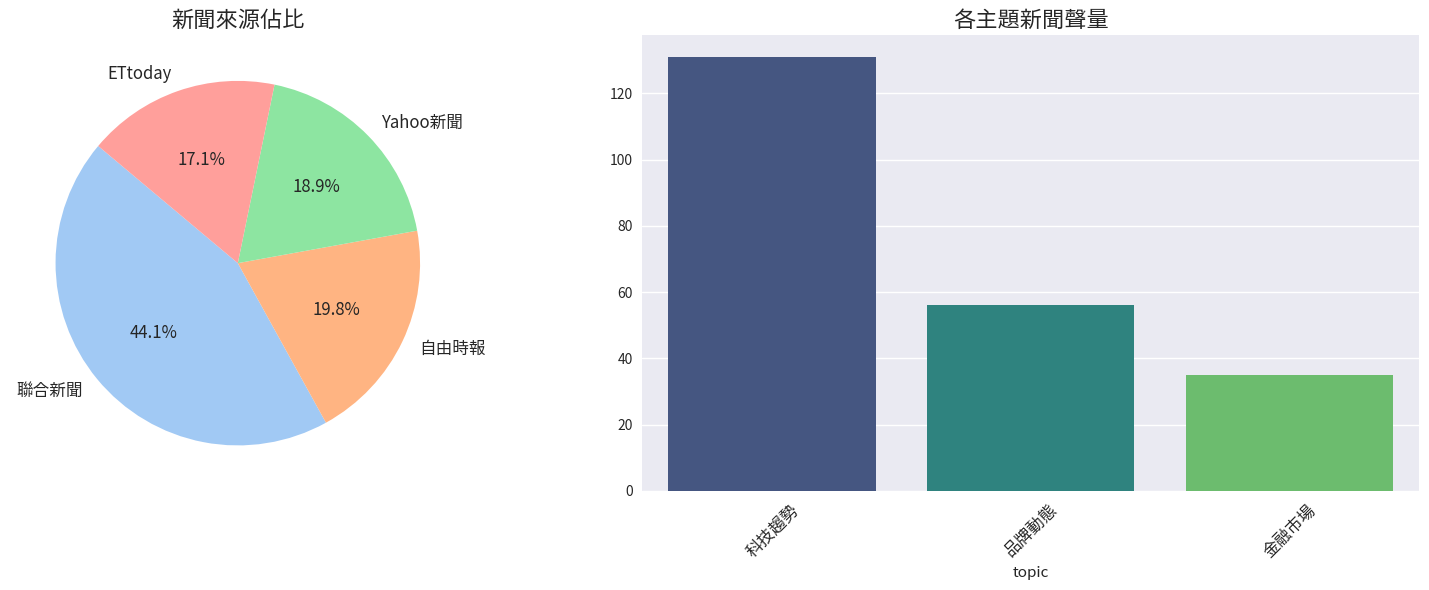

In [ ]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ==========================================
# 1. 環境設定
# ==========================================
# 如果還沒下載字型，這裡防呆下載一下
if not os.path.exists('TaipeiSansTCBeta-Regular.ttf'):
    !wget -q -O TaipeiSansTCBeta-Regular.ttf "https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download"

plt.style.use('seaborn-v0_8')
if os.path.exists('TaipeiSansTCBeta-Regular.ttf'):
    matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
    matplotlib.rc('font', family='Taipei Sans TC Beta')
    plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 2. 自動搜尋最新的 Excel (跨日期)
# ==========================================
def find_latest_excel():
    # 設定基礎路徑 (不包含日期)
    base_path = "/content/drive/My Drive/News_Crawler_Reports"

    if not os.path.exists(base_path):
        print(f"❌ 找不到基礎路徑：{base_path}")
        print("   請確認 Google Drive 是否已掛載？")
        return None

    print(f"🔍 正在搜尋 {base_path} 底下所有的 Excel 檔...")

    excel_files = []
    # 遞迴搜尋所有子資料夾
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith(".xlsx") and not file.startswith("~$"): # 排除暫存檔
                full_path = os.path.join(root, file)
                excel_files.append(full_path)

    if not excel_files:
        print("❌ 找不到任何 Excel 檔案。")
        return None

    # 依修改時間排序，取最新的
    latest_file = max(excel_files, key=os.path.getctime)
    print(f"✅ 找到最新的檔案：{latest_file}")
    return latest_file

# ==========================================
# 3. 報告檢查主程式
# ==========================================
def check_final_report(file_path):
    if not os.path.exists(file_path):
        print(f"❌ 找不到檔案：{file_path}")
        return

    # 讀取 Excel
    df = pd.read_excel(file_path)

    print(f"📊 報告健檢：{file_path.split('/')[-1]}")
    print(f"   📌 總資料筆數：{len(df)} 則")
    print("="*60)

    cols_map = {
        '來源': 'source', '監測主題': 'topic', '關鍵字': 'root_keyword',
        '發布時間': 'date', '新聞標題': 'title',
        'AI 重點摘要': 'ai_summary', 'AI 評語': 'relevance_reason'
    }
    df.rename(columns=cols_map, inplace=True)

    # [1] 來源分佈
    print("\n[1] 來源分佈:")
    print(df['source'].value_counts())

    # [2] 時間分佈
    df['date'] = pd.to_datetime(df['date'])
    print(f"\n[2] 時間範圍:")
    print(f"   🗓️ Start: {df['date'].min()}")
    print(f"   🗓️ End:   {df['date'].max()}")

    # [3] AI 摘要抽查 (修改處：增加為 5 則)
    sample_count = 5  # <--- 這裡設定要看幾則
    print(f"\n[3] AI 摘要抽查 (隨機 {sample_count} 則):")

    if len(df) > 0:
        # 確保資料不夠時不會報錯 (取最小值)
        real_sample_count = min(sample_count, len(df))
        samples = df.sample(n=real_sample_count)

        for i, row in samples.iterrows():
            print("-" * 60)
            print(f"🔹 標題：{row.get('title', 'N/A')}")
            print(f"   來源：{row.get('source', 'N/A')} | {row.get('topic', 'N/A')}")
            # 稍微放寬摘要顯示字數，讓你看得更完整
            print(f"   🤖 摘要：{str(row.get('ai_summary', 'N/A'))}")
            print(f"   ✅ 理由：\033[92m{str(row.get('relevance_reason', 'N/A'))}\033[0m")

    # 繪圖
    if len(df) > 0:
        try:
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))

            s_counts = df['source'].value_counts()
            colors = sns.color_palette('pastel')[0:len(s_counts)]
            axes[0].pie(s_counts, labels=s_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, textprops={'fontsize': 12})
            axes[0].set_title("新聞來源佔比", fontsize=16)

            t_counts = df['topic'].value_counts()
            sns.barplot(x=t_counts.index, y=t_counts.values, ax=axes[1], palette="viridis", hue=t_counts.index, legend=False)
            axes[1].set_title("各主題新聞聲量", fontsize=16)
            axes[1].tick_params(axis='x', rotation=45, labelsize=12)

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"\n⚠️ 繪圖失敗: {e}")

# === 執行 ===
target_file = find_latest_excel()
if target_file:
    check_final_report(target_file)

# 簡易儀錶板

In [ ]:
!pip install gradio > /dev/null 2>&1

import gradio as gr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import os

# ==========================================
# 1. 環境與字型設定
# ==========================================
font_filename = "TaipeiSansTCBeta-Regular.ttf"

# 檢查字型是否存在，若無則下載
if not os.path.exists(font_filename):
    !wget -q -O TaipeiSansTCBeta-Regular.ttf "https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download"

# 設定全域字型
try:
    fm.fontManager.addfont(font_filename)
    plt.rcParams['font.family'] = 'Taipei Sans TC Beta'
    plt.rcParams['axes.unicode_minus'] = False
    print("✅ 字型設定完成 (Taipei Sans TC Beta)")
except Exception as e:
    print(f"⚠️ 字型設定失敗: {e}")

# ==========================================
# 2. 資料載入邏輯 (記憶體 -> 硬碟)
# ==========================================
def load_data():
    # 優先嘗試讀取記憶體中的變數
    if 'export_df' in globals() and isinstance(export_df, pd.DataFrame) and not export_df.empty:
        print("📂 讀取來源: 記憶體變數 (export_df)")
        return export_df.copy()

    # 若無，則搜尋硬碟中最新的 Excel
    print("📂 讀取來源: 硬碟檔案 (搜尋中...)")
    base_path = "/content/drive/My Drive/News_Crawler_Reports"
    if not os.path.exists(base_path):
        return pd.DataFrame()

    excel_files = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith(".xlsx") and not file.startswith("~$"):
                excel_files.append(os.path.join(root, file))

    if excel_files:
        latest_file = max(excel_files, key=os.path.getctime)
        print(f"   -> 載入檔案: {latest_file.split('/')[-1]}")
        return pd.read_excel(latest_file)

    return pd.DataFrame()

# 載入資料
df_dashboard = load_data()

# ==========================================
# 3. 儀表板核心邏輯
# ==========================================
def dashboard_analytics(topic_filter):
    if df_dashboard.empty:
        return "❌ 無資料可顯示", None, None, []

    # 篩選資料
    df_view = df_dashboard.copy()
    if topic_filter != "全部":
        df_view = df_view[df_view['監測主題'] == topic_filter]

    total_count = len(df_view)
    if total_count == 0:
        return "查無符合資料", None, None, []

    # --- 圖表 A: 來源分佈 ---
    fig1, ax1 = plt.subplots(figsize=(6, 4))
    source_counts = df_view['來源'].value_counts()
    # 使用 pastel 色系比較柔和
    colors = sns.color_palette('pastel')[0:len(source_counts)]
    ax1.pie(source_counts, labels=source_counts.index, autopct='%1.1f%%',
            startangle=140, colors=colors, textprops={'fontsize': 10})
    ax1.set_title(f"新聞來源佔比", fontsize=14)
    plt.tight_layout()

    # --- 圖表 B: 情緒分佈 ---
    fig2, ax2 = plt.subplots(figsize=(6, 4))
    if '情緒' in df_view.columns:
        sentiment_counts = df_view['情緒'].value_counts()
        # 指定顏色：正面綠、負面紅、中立灰
        color_map = {'正面': '#2ca02c', '負面': '#d62728', '中立': '#7f7f7f'}
        sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=ax2, palette=color_map)
        ax2.set_title(f"AI 情緒分析", fontsize=14)
        ax2.set_ylabel("篇數")
    else:
        ax2.text(0.5, 0.5, "無情緒資料", ha='center', va='center')
    plt.tight_layout()

    # --- 表格預覽 ---
    # 選取重要欄位展示
    preview_cols = ['新聞標題', '發布時間', 'AI 重點摘要', 'AI 評語']
    # 確保欄位存在
    valid_cols = [c for c in preview_cols if c in df_view.columns]
    preview_data = df_view[valid_cols].head(10).values.tolist()

    return f"共找到 {total_count} 則新聞", fig1, fig2, preview_data

# ==========================================
# 4. 建立 Gradio 介面
# ==========================================
try:
    # 製作下拉選單選項
    if not df_dashboard.empty and '監測主題' in df_dashboard.columns:
        topics = ["全部"] + list(df_dashboard['監測主題'].unique())
    else:
        topics = ["全部"]
except:
    topics = ["全部"]

with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 📊 AI 商業情報儀錶板 (Live Demo)")
    gr.Markdown(f"資料日期: {datetime.now().strftime('%Y-%m-%d')} | 來源: Python 自動化爬蟲系統")

    with gr.Row():
        with gr.Column(scale=1):
            topic_dropdown = gr.Dropdown(choices=topics, value="全部", label="🔍 選擇監測主題")
            result_text = gr.Textbox(label="統計數據", value="請選擇主題以開始分析")

        with gr.Column(scale=2):
            pass # 空白佔位用

    with gr.Row():
        plot1 = gr.Plot(label="來源分佈")
        plot2 = gr.Plot(label="情緒趨勢")

    gr.Markdown("### 📋 最新高價值情報 (前 10 篇)")
    data_table = gr.Dataframe(
        headers=["標題", "時間", "摘要", "AI 評語"],
        datatype=["str", "str", "str", "str"],
        wrap=True,
        interactive=False
    )

    # 設定互動邏輯 (當下拉選單改變時觸發)
    topic_dropdown.change(
        fn=dashboard_analytics,
        inputs=topic_dropdown,
        outputs=[result_text, plot1, plot2, data_table]
    )

    # 啟動時自動執行一次
    demo.load(
        fn=dashboard_analytics,
        inputs=topic_dropdown,
        outputs=[result_text, plot1, plot2, data_table]
    )

# 啟動 (share=True 可以產生公開連結分享給別人看，適合 Demo)
print("🚀 儀錶板啟動中... 請點擊下方的 URL")
demo.launch(debug=True, share=True)

✅ 字型設定完成 (Taipei Sans TC Beta)
📂 讀取來源: 硬碟檔案 (搜尋中...)
   -> 載入檔案: News_Report_20251126_2153_.xlsx


/tmp/ipython-input-2589504035.py:119: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as demo:


🚀 儀錶板啟動中... 請點擊下方的 URL
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://fa47031496bf26caff.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/tmp/ipython-input-2589504035.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=ax2, palette=color_map)
/tmp/ipython-input-2589504035.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=ax2, palette=color_map)
/tmp/ipython-input-2589504035.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=ax2, palette=color_map)
/tmp/ipython-input-2589504035.py:91: FutureWarning: 

Pass

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://fa47031496bf26caff.gradio.live
